# Урок 5. Улучшаем модель.¶

## Описание системы

В рамках данного проекта разрабатывается система для прогнозирования сроков строительства базовых станций сотовой связи.<br />
Отличительной особенностью системы является то, что на начальных этапах отсутствует вся информация о ключевых этапах технологического процесса.
1. На начальном этапе известны только параметры присущие самому планируемому объекту связи, такие как, место размещения, тип объекта, технологии, которые планируется строить, сопряженные объекты связи. По этим данным система прогнозирует предварительный срок строительства объекта связи. На данном этапе допустима точность прогнозирования в пределах одного квартала.
2. По мере работы над строительством базовой станции появляются даты важных производственных этапов. Каждый дополнительный шаг производственного процесса приводит к появлению дополнительного признака, который уточняет прогноз. Прогнозы с момента эатапа выдачи оборудования должны быть в пределах недели.
3. Кроме уже описанного с помощью системы должна быть предусмотрена возможность прогнозирования сроков каждого из этапов строительства.

На предыдущем в качестве модели показавшей лучшие результаты выбрана модель на базе XGBoost. Полученные с помощью данной модели метрики сформировали бейзлайн который на начальном этапе, когда есть только данные по объекту связи, даёт приемлемый результат, но на конечном этапе, когда остается только монтировать оборудование, не достаточно точные предсказания. Задача текущей работы улучшить результат предсказаний на конечных этапах бизнес-процесса строительства и модернизации объекта связи. На предыдущем этапе были получены следующие метрики:

In [1]:
import os, pandas as pd, numpy as np, optuna, joblib, xgboost as xgb, time
from datetime import timedelta
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from clearml import Task, Logger

%matplotlib inline
SEED = 16

In [3]:
df_metrics = pd.read_csv('metrics.csv', index_col=0)
df_metrics

,model,metrics,delta_start,delta_tech,delta_spe,delta_equipment,delta_contractor,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,LinearRegression,MAE,92.609013,51.147912,33.557495,31.433563,31.390799,27.970263,27.000443,20.316744,20.216525,15.918058
1,LinearRegression,R2,0.578895,0.842633,0.925458,0.934392,0.934541,0.945606,0.949182,0.960588,0.961652,0.971010
2,RandomForest,MAE,46.680380,29.462298,23.385902,22.538913,22.092643,20.950492,21.490633,20.880762,18.020890,21.783958
3,RandomForest,R2,0.861373,0.933070,0.953903,0.956564,0.956870,0.959608,0.958577,0.961675,0.964513,0.959130
4,XGBoost,MAE,47.842237,29.852947,23.619923,22.397606,21.304948,20.315469,20.454910,16.342203,16.492175,15.118602
5,XGBoost,R2,0.851021,0.929951,0.952244,0.954116,0.956976,0.960261,0.959536,0.966337,0.969328,0.972012


# Пайплайн предобработки

Для предобработки будем использовать csv файл подготовленный на предыдущем этапе. Он имеет следующие поля:

In [5]:
fields = ['year', 'type_of_work', 'contractor', 'idleft', 'idright', 
          '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place',
          'delta_start', 'delta_tech', 'delta_spe', 'delta_equipment', 
          'delta_contractor', 'delta_ready', 'delta_params', 'delta_integration',
          'delta_monitoring', 'delta_commisioning', 'delta_all']

<table>
    <tr>
        <th>Наименование поля</th>
        <th>Тип данных</th>
        <th>Тип признака</th>
        <th>Описание</th>
    </tr>
    <tr>
        <td>id</td>
        <td>Целочисленный</td>
        <td>Индекс</td>
        <td>Уникальный идентификатор работ</td>
    </tr>
    <tr>
        <td>year</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Год проведения работ</td>
    </tr>
    <tr>
        <td>contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Номер подрядной организации</td>
    </tr>
    <tr>
        <td>idleft</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор объекта связи</td>
    </tr>
    <tr>
        <td>idright</td>
        <td>Числовой</td>
        <td>Категориальный</td>
        <td>Уникальный идентификатор сопряженного объекта связи</td>
    </tr>
    <tr>
        <td>2g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>3g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>4g</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>rrl</td>
        <td>Числовой</td>
        <td>Бинарный, one hot encoding</td>
        <td>Строящаюся или реконструируемая технология на объекте связи</td>
    </tr>
    <tr>
        <td>a_index</td>
        <td>Целочисленный</td>
        <td>Числовой</td>
        <td>Признак места размещения объекта</td>
    </tr>
    <tr>
        <td>a_region</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Регион размещения объекта</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>a_place</td>
        <td>Вещественный</td>
        <td>Бинарный</td>
        <td>Признак размещения объекта город или нет</td>
    </tr>
    <tr>
        <td>delta_start</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от добавления в систему до начала работ</td>
    </tr>
    <tr>
        <td>delta_tech</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до готовности технической части</td>
    </tr>
    <tr>
        <td>delta_spe</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до заказа оборудования</td>
    </tr>
    <tr>
        <td>delta_equipment</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от начала работ до комплектации</td>
    </tr> 
    <tr>
        <td>delta_contractor</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности технической части до проектирования</td>
    </tr>  
    <tr>
        <td>delta_ready</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от комплектации до готовности к пуску</td>
    </tr> 
    <tr>
        <td>delta_params</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до готовности параметров</td>
    </tr> 
    <tr>
        <td>delta_integration</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_monitoring</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Количество дней от готовности к пуску до интеграции</td>
    </tr> 
    <tr>
        <td>delta_all</td>
        <td>Вещественный</td>
        <td>Числовой</td>
        <td>Все время работ в днях</td>
    </tr> 
</table>

Так же в качестве базы для улучшения модели будем использовать лучшие параметры найденные для модели XGBoost на предыдущем этапе проекта.

In [7]:
df_params = pd.read_csv('best_params.csv', index_col=0)
df_params

,learning_rate,max_depth,subsample,colsample_bytree,alpha,lambda
stage,,,,,,
delta_start,0.108432,10,0.862535,0.831152,0.219518,0.697791
delta_tech,0.139447,10,0.765737,0.882248,0.679838,0.552682
delta_spe,0.095579,10,0.906430,0.860987,0.021555,0.630976
delta_equipment,0.201596,9,0.969319,0.997874,0.469420,0.280563
delta_contractor,0.081193,10,0.960769,0.979082,0.939104,0.209085
delta_ready,0.105634,9,0.638910,0.954059,0.113777,0.606741
delta_params,0.140524,10,0.905094,0.980394,0.375960,0.569611
delta_integration,0.121475,8,0.925496,0.984612,0.378143,0.189189
delta_monitoring,0.114509,10,0.996741,0.934200,0.809654,0.714756


Подготавливаем обучающую функцию:

In [9]:
ROUNDS = 800
xgb_models = []

def XGBOnlyLearn(df, feature, params, subfields):
    idx = feature
    print("********************************************")
    print(f"Predict delta_all with features {subfields}")
    X = df[subfields]
    y = df[fields[target]]
    best_params = params
    best_params['objective'] = 'reg:absoluteerror'
    best_params['eval_metric'] = 'mae'
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    
    num_round = ROUNDS
    
    xgb_models.append(xgb.train(
                                best_params,
                                dtrain,
                                num_round,
                                evals=evals,
                                early_stopping_rounds=50,  # Увеличим терпение для ранней остановки
                                verbose_eval=20
                            )
                        )
    y_pred = xgb_models[-1].predict(dtest)
    print("\nМетрики качества:")
    MAE, R2 = mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
    print(f"Средняя абсолютная ошибка (MAE): {MAE}")
    print(f"Коэффициент детерминации (R²): {R2}")
    task.close()
    return MAE, R2

Готовим данные и обучаем модель:

In [25]:
start = time.perf_counter() #Для подсчета времени работы

url = 'https://github.com/morebobah/MFDP/raw/refs/heads/main/Task_5_Improving_The_Model/stage_temp.csv' 
df = pd.read_csv(url, index_col=0) # Загружаем данные подготовленные на предыдущем этапе для экономии времени
#При необходимости можем использовать пайплайн из предыдущего этапа, с помощью него можно получить stage_temp.csv,
#который отличается только тем, что в нем предобработаны значения из поля address, они разбиты и подготовлены для эмбединга
#Переводим строковые даты в формат datatime
fld = [x for x in df.columns if x==x.upper()] #Спсиок полей с именами в верхнем регистре
for f in fld:
    df[f] = pd.to_datetime(df[f], format='%Y-%m-%d %H:%M:%S')
df['date_start'] = pd.to_datetime(df['date_start'], format='%Y-%m-%d') #Плюс два поля с датами с именами в нижнем регистре
df['date_fin'] = pd.to_datetime(df['date_fin'], format='%Y-%m-%d') #Плюс два поля с датами с именами в нижнем регистре

#Агрегируем данные по полям учет по отдельности которых не имеет смысла
fields = {'tech': ['TECH_TASK_TRM', 'TECH_TASK_ENERGO', 'TECH_TASK_RADIO', 'TECH_TASK_CONTRACTOR'],
          'equipment': ['EQUIPMENT_TRM', 'EQUIPMENT_ENERGO', 'EQUIPMENT_STUFF', 'EQUIPMENT_RADIO'], 
          'integration': ['INTEGRATION_2G', 'INTEGRATION_3G', 'INTEGRATION_4G', 'INTEGRATION_TRM'], 
          'monitoring': ['MONITORING_ASSEPTANCE_2G', 'MONITORING_ASSEPTANCE_3G', 'MONITORING_ASSEPTANCE_4G', 'MONITORING_ASSEPTANCE_TRM'], 
          'commisioning': ['COMMISSIONING_2G', 'COMMISSIONING_3G', 'COMMISSIONING_4G'], 
          'params': ['PARAMS_TRM', 'PARAMS_RADIO']}
for key, val in fields.items():
    df[f'{key}_fin'] = df[val].max(axis=1)

#Вычисляем разницы по времени, добавлем новые фичи
df['delta_all'] = (df['date_fin'] - df['date_start'])/timedelta(days=1) #Все время работ в днях
df['delta_start'] = (df['ADR_PREPARE'] - df['date_start'])/timedelta(days=1) #Время от добавления в систему до начала работ
df['delta_tech'] = (df['tech_fin'] - df['ADR_PREPARE'])/timedelta(days=1) #Время от начала работ до готовности технической части
df['delta_spe'] = (df['equipment_fin'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до заказа оборудования
df['delta_contractor'] = (df['CONTRACTOR_ACCEPTED'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до проектирования
df['delta_equipment'] = (df['EQUIPMENT_PREPARED'] - df['equipment_fin'])/timedelta(days=1) #Время от начала работ до комплектации
df['delta_ready'] = (df['READY_FOR_WORK'] - df['EQUIPMENT_PREPARED'])/timedelta(days=1) #Время от комплектации до готовности к пуску
df['delta_params'] = (df['params_fin'] - df['READY_FOR_WORK'])/timedelta(days=1) #Время от готовности к пуску до готовности параметров
df['delta_integration'] = (df['integration_fin'] - df['params_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_monitoring'] = (df['monitoring_fin'] - df['integration_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_commisioning'] = (df['commisioning_fin'] - df['monitoring_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции

#Заполняем нулями отсутствующие значения 
empty_fields = df.columns[df.isnull().any()].tolist()
for fld in empty_fields:
    df[fld] = df[fld].fillna(0)

xgb_metrics = [] #Сохраняем полученные метрики
iteration = 1 #Итерации для версионирования
df_leftout = df.copy(deep=True) #Откладываем полученый набор
target = len(fields) - 1 #Целевое поле всегда в конце
features = len(fields) - 11 #Разделитель постоянных фич, которые присущи объекту связи и переменных, которые добаляются с ходом техпроцесса
#Увеличивая features мы постепенно добавляем новые фичи либо для обучения модели, либо для предсказания. Всего получается 10 моделей
#каждая, под свой этап технологического процесса
#Проводим обучение моделей 
#Для обучения используем гиперпараметры полученные на предыдущем этапе
url = 'https://raw.githubusercontent.com/morebobah/MFDP/refs/heads/main/Task_5_Improving_The_Model/best_params.csv'
df_params = pd.read_csv('best_params.csv', index_col=0)

for ydx in range(features, target):
    features_step = ydx - features
    print(f'Шаг {iteration}. Миксуем в набор данные о месяце появления данных о фиче: {fields[ydx]}')
    metrics = {'feature': fields[ydx]}
    worked_fileds = fields[:ydx + 1]
    task_name = f'{iteration}. {fields[ydx]} only base fields'
    metrics['stage'] = 'base'
    df = df_leftout[worked_fileds + [fields[target]]]
    print(f"2. Время выполнения: {time.perf_counter() - start} секунд")
    #Для версионирования используем ClearML
    #Путь к версиям https://app.clear.ml/projects/fcc76519f6924081a6127206a545f261/tasks/72eb64b7aae94016a49074036960cdac/execution?columns=selected&columns=type&columns=name&columns=tags&columns=status&columns=project.name&columns=users&columns=started&columns=last_update&columns=last_iteration&columns=parent.name&order=-last_update&filter=
    task = Task.init(
        project_name='task 5 Improving The Model',
        task_name=task_name,
        output_uri=True, 
        auto_connect_frameworks=True
    )
    best_params = df_params.loc[fields[ydx]].to_dict()
    best_params['max_depth'] = int(best_params['max_depth'])
    task.connect(best_params)
    logger = task.get_logger()
    result = XGBOnlyLearn(df, ydx, best_params, worked_fileds) # COMMISIONING EQUIPMENT
    metrics['value'] = result
    xgb_metrics.append(metrics)
        
    logger.report_scalar(title="Средняя абсолютная ошибка (MAE):", series="EQUIPMENT", value=result[0], iteration=iteration)
    logger.report_scalar(title="Коэффициент детерминации (R²):", series="EQUIPMENT", value=result[1], iteration=iteration)
        
    iteration += 1
    print(f"3. Время выполнения: {time.perf_counter() - start} секунд")
    task.close()

# Улучшенная архитектура модели

Для улучшения предсказаний модели будем использовать следующие шаги:
1. Увеличим набор данных с 19999 записей до 41541 записи.
2. Будем исходить из предположения, что на скорость строительства влияют погодные условия. Получить признаки напрямую связанные с погодой проблематично, так как данные о метсах размещения объектов связи обфусцированы, поэтому будем использовать в качестве альтернативы месяц проведения работ, предполагаем, что в одни месяцы погода более подходит для работ в другие менее и это влияет на скорость их проведения. Добавим фичи с номерами месяцев по одной на каждый технологический процесс.
3. Попробуем скомбинировать предыдущую фичу с фичей обозначающей подрядчика.
Вносим изменения в пейплайн:

In [11]:
start = time.perf_counter()

url = 'stage_temp.csv'
df = pd.read_csv(url, index_col=0) # Загружаем данные

fld = [x for x in df.columns if x==x.upper()] #+ ['date_start', 'date_fin']
for f in fld:
    df[f] = pd.to_datetime(df[f], format='%Y-%m-%d %H:%M:%S')
df['date_start'] = pd.to_datetime(df['date_start'], format='%Y-%m-%d')
df['date_fin'] = pd.to_datetime(df['date_fin'], format='%Y-%m-%d')

fields = {'tech': ['TECH_TASK_TRM', 'TECH_TASK_ENERGO', 'TECH_TASK_RADIO', 'TECH_TASK_CONTRACTOR'],
          'equipment': ['EQUIPMENT_TRM', 'EQUIPMENT_ENERGO', 'EQUIPMENT_STUFF', 'EQUIPMENT_RADIO'], 
          'integration': ['INTEGRATION_2G', 'INTEGRATION_3G', 'INTEGRATION_4G', 'INTEGRATION_TRM'], 
          'monitoring': ['MONITORING_ASSEPTANCE_2G', 'MONITORING_ASSEPTANCE_3G', 'MONITORING_ASSEPTANCE_4G', 'MONITORING_ASSEPTANCE_TRM'], 
          'commisioning': ['COMMISSIONING_2G', 'COMMISSIONING_3G', 'COMMISSIONING_4G'], 
          'params': ['PARAMS_TRM', 'PARAMS_RADIO']}
for key, val in fields.items():
    df[f'{key}_fin'] = df[val].max(axis=1)

#*************************
#Добавлено по сравнению с предыдущим пейплайном
weather_fields = ['date_start', 'ADR_PREPARE', 'tech_fin', 'equipment_fin', 'EQUIPMENT_PREPARED', 'CONTRACTOR_ACCEPTED', 'READY_FOR_WORK', 'params_fin', 'integration_fin', 'monitoring_fin', 'commisioning_fin']
weather = []
for idx, wea in enumerate(weather_fields):
    print(idx, wea)
    df[f'weather{idx}'] = pd.to_datetime(df[wea], format='%Y-%m-%d').dt.month
    weather.append(f'weather{idx}')
#****************************

df['delta_all'] = (df['date_fin'] - df['date_start'])/timedelta(days=1) #Все время работ в днях
df['delta_start'] = (df['ADR_PREPARE'] - df['date_start'])/timedelta(days=1) #Время от добавления в систему до начала работ
df['delta_tech'] = (df['tech_fin'] - df['ADR_PREPARE'])/timedelta(days=1) #Время от начала работ до готовности технической части
df['delta_spe'] = (df['equipment_fin'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до заказа оборудования
df['delta_contractor'] = (df['CONTRACTOR_ACCEPTED'] - df['tech_fin'])/timedelta(days=1) #Время от готовности технической части до проектирования
df['delta_equipment'] = (df['EQUIPMENT_PREPARED'] - df['equipment_fin'])/timedelta(days=1) #Время от начала работ до комплектации
df['delta_ready'] = (df['READY_FOR_WORK'] - df['EQUIPMENT_PREPARED'])/timedelta(days=1) #Время от комплектации до готовности к пуску
df['delta_params'] = (df['params_fin'] - df['READY_FOR_WORK'])/timedelta(days=1) #Время от готовности к пуску до готовности параметров
df['delta_integration'] = (df['integration_fin'] - df['params_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_monitoring'] = (df['monitoring_fin'] - df['integration_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции
df['delta_commisioning'] = (df['commisioning_fin'] - df['monitoring_fin'])/timedelta(days=1) #Время от готовности к пуску до интеграции

print(f"1. Время выполнения: {time.perf_counter() - start} секунд")

#*****************************
#Добавлено по сравнению с предыдущим пейплайном
contractor_weather = []
for idx, wea in enumerate(weather_fields):
    print(idx, wea)
    df[f'cw{idx}'] = df['contractor'] * 100 + df[f'weather{idx}']
    contractor_weather.append(f'cw{idx}')
#**********************************

empty_fields = df.columns[df.isnull().any()].tolist()
for fld in empty_fields:
    df[fld] = df[fld].fillna(0)

df_leftout = df.copy(deep=True)
fields = ['year', 'type_of_work', 'contractor', 'idleft', 'idright', 
          '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', #*weather, *contractor_weather, 
          'delta_start', 'delta_tech', 'delta_spe', 'delta_contractor', 
          'delta_equipment', 'delta_ready', 'delta_params', 'delta_integration',
          'delta_monitoring', 'delta_commisioning', 'delta_all']

xgb_metrics = []
iteration = 1
target = len(fields) - 1 #Целевое поле
features = len(fields) - 11
url = 'https://raw.githubusercontent.com/morebobah/MFDP/refs/heads/main/Task_5_Improving_The_Model/best_params.csv'
df_params = pd.read_csv('best_params.csv', index_col=0)
for ydx in range(features, target):
    features_step = ydx - features
    print(f'Шаг {iteration}. Миксуем в набор данные о месяце появления данных о фиче: {fields[ydx]}')
    for zdx in range(1, 4):
        metrics = {'feature': fields[ydx]}
        #*************************
        #Добавлены наборы полей под различные варианты обучения
        if zdx % 3 == 0:
            worked_fileds = fields[:ydx + 1] + weather[:features_step + 1] + contractor_weather[:features_step + 1]
            task_name = f'{iteration}. {fields[ydx]} + weather + contractor*weather'
            metrics['stage'] = 'weather+contractor'
        elif zdx % 2 == 0:
            worked_fileds = fields[:ydx + 1] + weather[:features_step + 1]
            task_name = f'{iteration}. {fields[ydx]} + only weather'
            metrics['stage'] = 'weather'
        else:
            worked_fileds = fields[:ydx + 1]
            task_name = f'{iteration}. {fields[ydx]} only base fields'
            metrics['stage'] = 'base'
        #********************************
        
        print(worked_fileds)
        print(task_name)
        df = df_leftout[worked_fileds + [fields[target]]]
        print(f"2. Время выполнения: {time.perf_counter() - start} секунд")
        task = Task.init(
            project_name='task 5 Improving The Model',
            task_name=task_name,
            output_uri=True, 
            auto_connect_frameworks=True
        )

        best_params = df_params.loc[fields[ydx]].to_dict()
        best_params['max_depth'] = int(best_params['max_depth'])
        task.connect(best_params)
        logger = task.get_logger()
        result = XGBOnlyLearn(df, ydx, best_params, worked_fileds) # COMMISIONING EQUIPMENT
        metrics['value'] = result
        xgb_metrics.append(metrics)
        
        logger.report_scalar(title="Средняя абсолютная ошибка (MAE):", series="EQUIPMENT", value=result[0], iteration=iteration)
        logger.report_scalar(title="Коэффициент детерминации (R²):", series="EQUIPMENT", value=result[1], iteration=iteration)
        
        iteration += 1
        print(f"3. Время выполнения: {time.perf_counter() - start} секунд")
        task.close()

0 date_start
1 ADR_PREPARE
2 tech_fin
3 equipment_fin
4 EQUIPMENT_PREPARED
5 CONTRACTOR_ACCEPTED
6 READY_FOR_WORK
7 params_fin
8 integration_fin
9 monitoring_fin
10 commisioning_fin
1. Время выполнения: 1.2880040000018198 секунд
0 date_start
1 ADR_PREPARE
2 tech_fin
3 equipment_fin
4 EQUIPMENT_PREPARED
5 CONTRACTOR_ACCEPTED
6 READY_FOR_WORK
7 params_fin
8 integration_fin
9 monitoring_fin
10 commisioning_fin
Шаг 1. Миксуем в набор данные о месяце появления данных о фиче: delta_start
['year', 'type_of_work', 'contractor', 'idleft', 'idright', '2g', '3g', '4g', 'rrl', 'a_index', 'a_region', 'a_place', 'delta_start']
1. delta_start only base fields
2. Время выполнения: 2.8418908000021474 секунд
ClearML Task: created new task id=9acba545039649e29ea3a3148d1b0afa
2025-07-06 20:22:39,281 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fcc76519f6924081a6127206a545f261/experiments/9acba545039649e29ea3a3148d1b0afa/output/log
**

Получаем такие результаты:

In [18]:
rows = []
#XGBoost MAE base
d1 = {'model': 'XGBoost', 'metrics': 'MAE', 'stage': 'base'}
#XGBoost R2 base
d2 = {'model': 'XGBoost', 'metrics': 'R2', 'stage': 'base'}
#XGBoost MAE weather
d3 = {'model': 'XGBoost', 'metrics': 'MAE', 'stage': 'weather'}
#XGBoost R2 weather
d4 = {'model': 'XGBoost', 'metrics': 'R2', 'stage': 'weather'}
#XGBoost MAE weather+contractor
d5 = {'model': 'XGBoost', 'metrics': 'MAE', 'stage': 'weather+contractor'}
#XGBoost R2 weather+contractor
d6 = {'model': 'XGBoost', 'metrics': 'R2', 'stage': 'weather+contractor'}
for item in xgb_metrics:
    
    if item['stage']=='base':
        d1[item['feature']] = item['value'][0]
        d2[item['feature']] = item['value'][1]
    elif item['stage']=='weather':
        d3[item['feature']] = item['value'][0]
        d4[item['feature']] = item['value'][1]
    else:
        d5[item['feature']] = item['value'][0]
        d6[item['feature']] = item['value'][1]
df_compare = pd.DataFrame([d1, d2, d3, d4, d5, d6])
df_compare.to_csv('metrics_compare.csv', index=False)
df_compare

,model,metrics,stage,delta_start,delta_tech,delta_spe,delta_contractor,delta_equipment,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,XGBoost,MAE,base,56.594399,29.545530,23.383630,22.537479,21.386023,18.696373,18.881378,15.290109,15.243609,13.111811
1,XGBoost,R2,base,0.776228,0.926570,0.951090,0.952808,0.951421,0.961307,0.960699,0.965050,0.968552,0.973738
2,XGBoost,MAE,weather,54.206181,28.595522,22.872365,22.208596,20.716103,18.788497,18.450578,14.967003,15.052376,13.123803
3,XGBoost,R2,weather,0.786306,0.934675,0.952543,0.951834,0.955679,0.961419,0.962602,0.966892,0.964558,0.971420
4,XGBoost,MAE,weather+contractor,54.762226,29.018884,22.502065,22.016758,20.729898,18.847571,18.536401,14.840810,15.528091,13.661480
5,XGBoost,R2,weather+contractor,0.783285,0.930668,0.952130,0.953723,0.956449,0.960209,0.962319,0.968575,0.964601,0.972320


По результатам видны следующие факты:
1. Добавление записей ухудшило предсказания, особенно на начальных этапах технологического процесса, но улучило предсказания в конце. Возможная причина увеличение тестовой части выборки на которой проводится проверка. Возможно требуется снова подобрать гиперпараметры.
2. Добавление фичи с номером месяца улучшило предсказание базовой модели на увеличенном наборе.
3. Фича с просто номером месяца и комбинированная конкурируют друг с другом за лучший MAE.
Для итоговой улучшенной архитектуры выберем модели с наименьшими MAE:

In [35]:
best_models = [1, 4, 8, 11, 13, 15, 19, 23, 25, 27] # Лучшие модели имеют такие порядковые номера в списке xgb_models

Сохраняем полученные результаты:

In [37]:
names = ['delta_start', 'delta_tech', 
         'delta_spe', 'delta_contractor', 
         'delta_equipment', 'delta_ready', 
         'delta_params', 'delta_integration',
         'delta_monitoring', 'delta_commisioning']
stages = ['base', 'weather', 'wthc']
idx = 0
#Сначала сохраняем все модели
for name in names:
    for stage in stages:
        joblib.dump(xgb_models[idx], f'xgb_model_{name}_{stage}.pkl')
        idx += idx

#Потом сохраняем выбранные модели
for idx, name in enumerate(names):
    joblib.dump(xgb_models[best_models[idx]], f'xgb_model_{name}.pkl')

# Постобработка предсказаний

Загружаем сохранененные модели:

In [42]:
url = 'https://raw.githubusercontent.com/morebobah/MFDP/refs/heads/main/Task_5_Improving_The_Model/best_params.csv'
df_params = pd.read_csv('best_params.csv', index_col=0)
xgb_models_best = {idx: None for idx in df_params.index}
keys = xgb_models_best.keys()
for model in [model for model in os.listdir() if model.endswith('.pkl')]:
    if model[10:-4] in keys:
        xgb_models_best[model[10:-4]] = joblib.load(model)

Посмотрим на распределение ошибки по всем моделям:

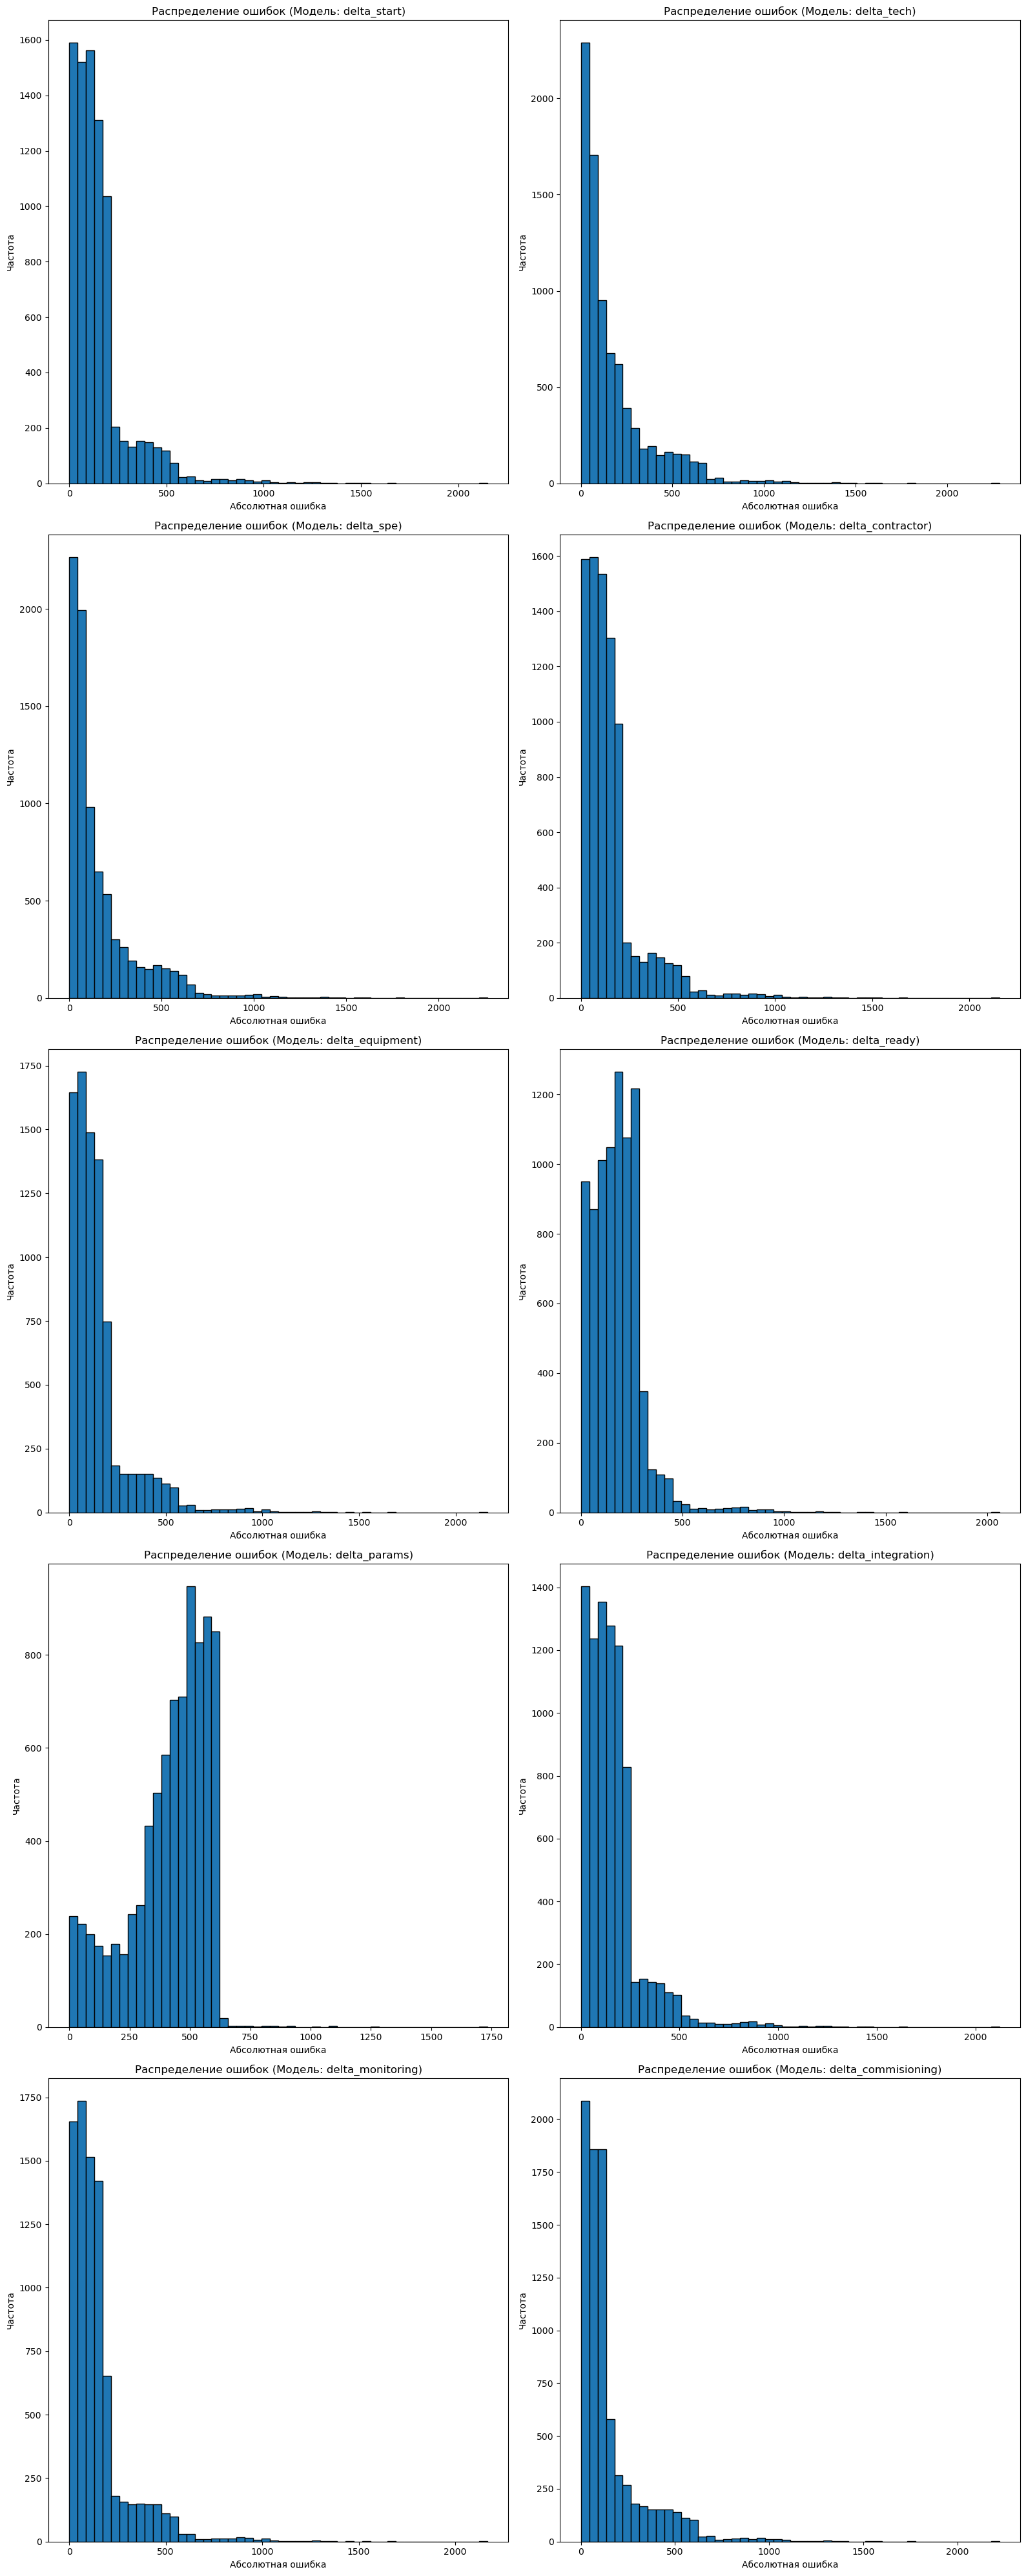

In [71]:
target = 22
features = 12

def prepareXGB(subfields):
    X = df_leftout[subfields]
    y = df_leftout[fields[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=SEED)
    return xgb.DMatrix(X_test, label=y_test), y_test

mae_errors = []

for idx in range(features, target):
    try:
        dtest, y_test = prepareXGB(fields[:idx  + 1])
        y_pred = xgb_models_best[fields[idx]].predict(dtest)
    except ValueError:
        try:
            dtest, y_test = prepareXGB(fields[:idx  + 1] + weather[:idx-features+1])
            y_pred = xgb_models_best[fields[idx]].predict(dtest)
        except ValueError:
            dtest, y_test = prepareXGB(fields[:idx  + 1] + weather[:idx-features+1] + contractor_weather[:idx-features+1])
            y_pred = xgb_models_best[fields[idx]].predict(dtest)
    mae_errors.append((y_test, y_pred))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 40))

for idx, (model, ax) in enumerate(zip(mae_errors, axes.flatten())):
    errors = np.abs(y_test - y_pred[idx])
    ax.hist(errors, bins=50, edgecolor='black')
    ax.set_title(f"Распределение ошибок (Модель: {fields[idx + features]})")
    ax.set_xlabel('Абсолютная ошибка')
    ax.set_ylabel('Частота')

if len(mae_errors) < 5*2:
    for jdx in range(len(mae_errors), 5*2):
        axes.flatten()[jdx].axis('off')

plt.tight_layout()
plt.show()

На приведенных графиках распределений видим распределения отличные от равномерных, в основном распределения похожи на экспоненциальные, в случае добавления параметров delta_params, delta_ready видим распределения похожии на распределение Стьюдента. Выведем дополнительно графики остатков:

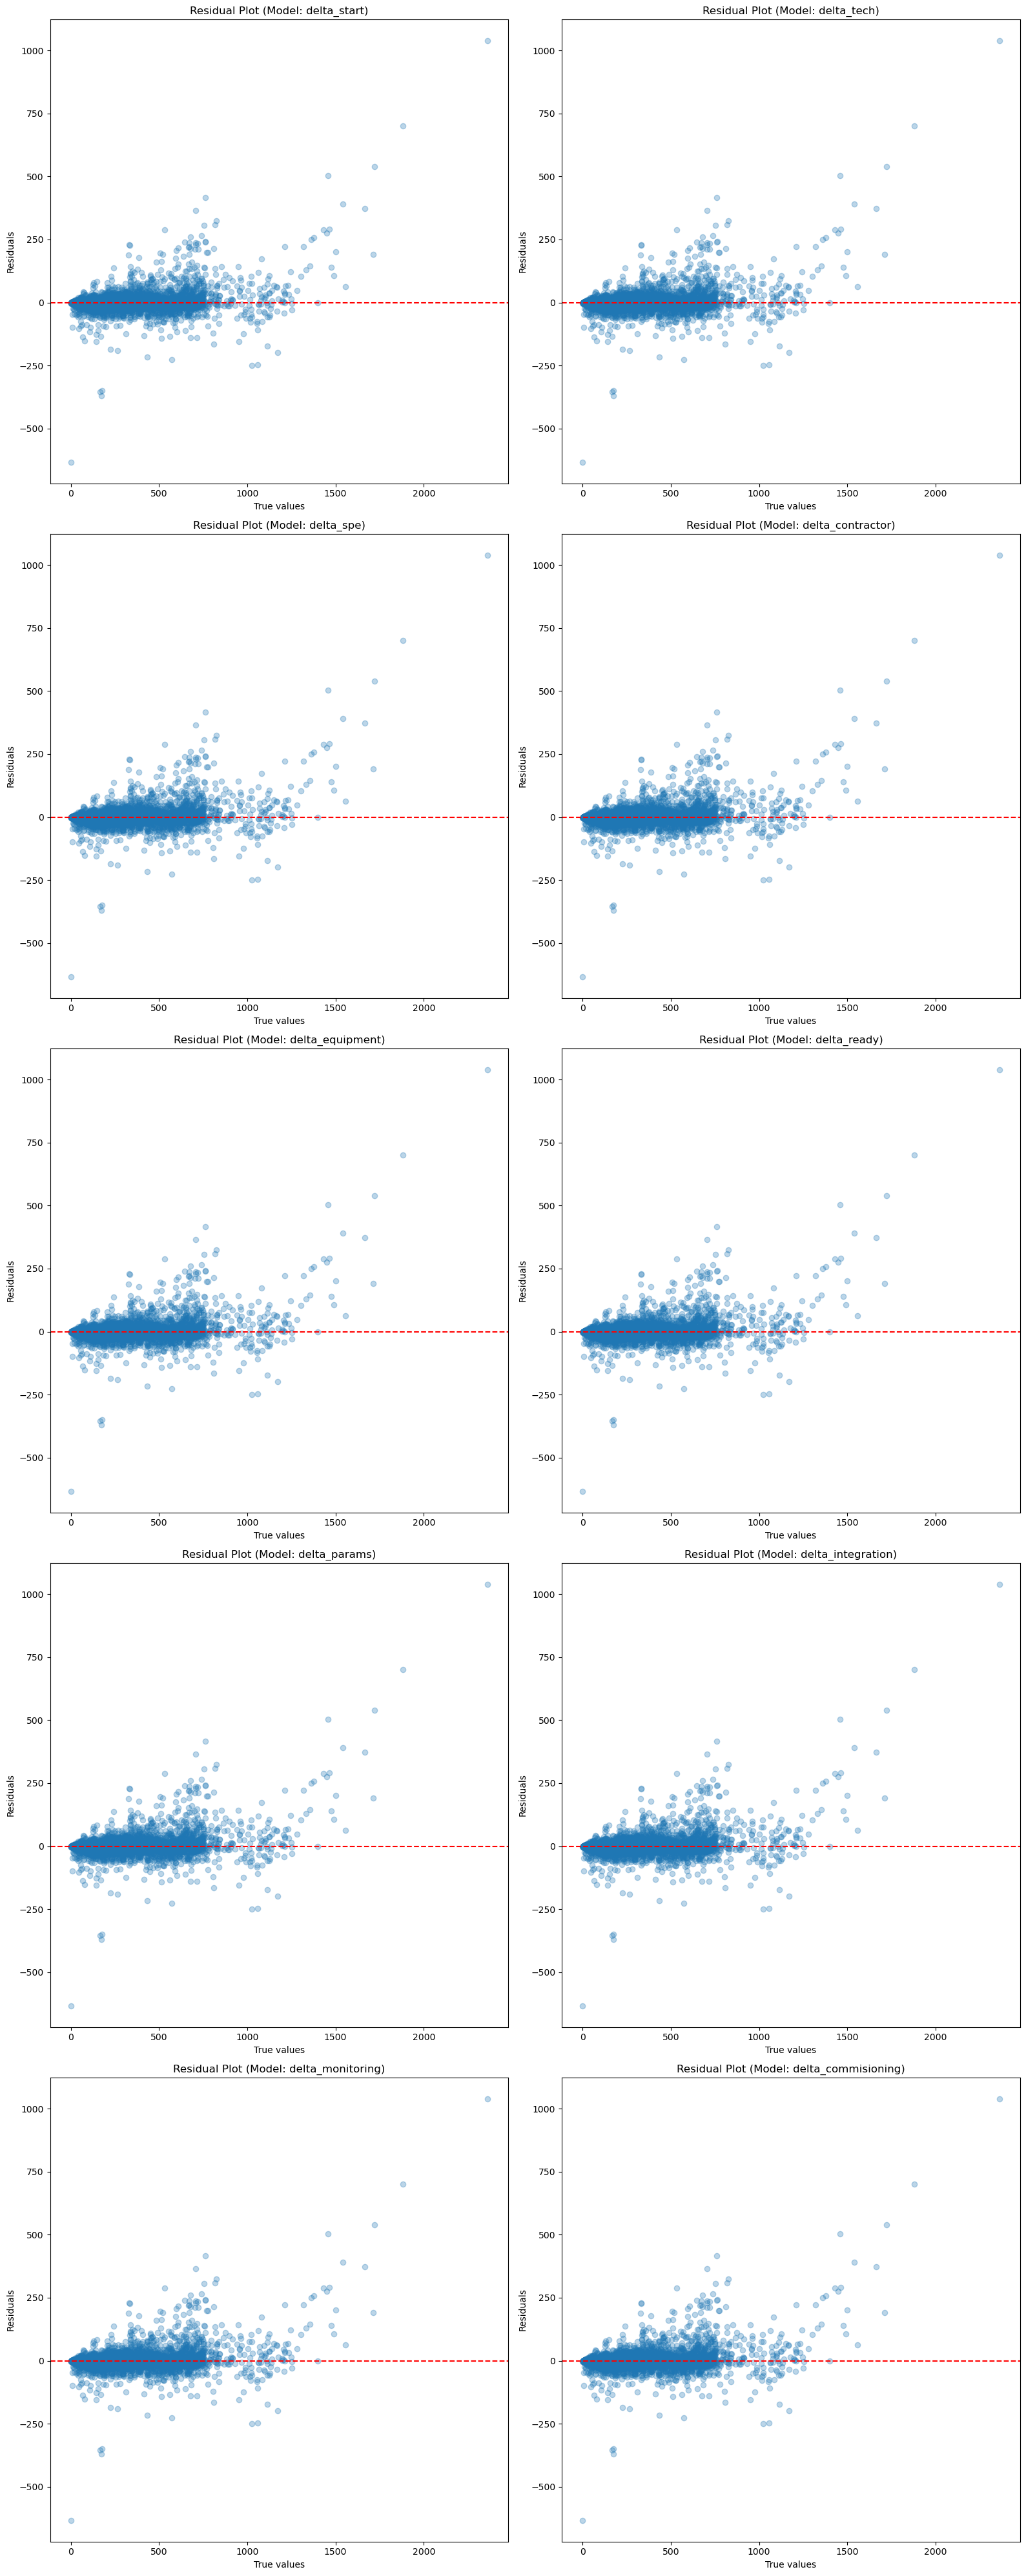

In [77]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 40))

for idx, (model, ax) in enumerate(zip(mae_errors, axes.flatten())):
    residuals = y_test - y_pred
    ax.scatter(y_test, residuals, alpha=0.3)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_xlabel("True values")
    ax.set_ylabel("Residuals")
    ax.set_title(f"Residual Plot (Model: {fields[idx + features]})")

if len(mae_errors) < 5*2:
    for jdx in range(len(mae_errors), 5*2):
        axes.flatten()[jdx].axis('off')

plt.tight_layout()
plt.show()

По графикам остатков видно, что большинество значительных отклонений видно при больших фактических значениях.

In [84]:
for (y_test, y_pred) in mae_errors:
    calib_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    calib_df['bin'] = pd.qcut(calib_df['y_true'], q=10, duplicates='drop')
    bin_stats = calib_df.groupby('bin', observed=True).agg({'y_true': 'mean', 'y_pred': 'mean'}).reset_index()
    bin_stats['correction_factor'] = bin_stats['y_true'] / bin_stats['y_pred']
    calib_df = calib_df.merge(bin_stats[['bin', 'correction_factor']], on='bin', how='left')
    calib_df['y_pred_calibrated'] = calib_df['y_pred'] * calib_df['correction_factor']
    mae_before = np.abs(calib_df['y_true'] - calib_df['y_pred']).mean()
    mae_after = np.abs(calib_df['y_true'] - calib_df['y_pred_calibrated']).mean()
    print(mae_before, mae_after)

54.20618078877186 53.77991739057886
28.59552164275353 30.05775889241005
22.50206529159439 23.620081031527846
22.016758427110194 23.429564180036852
20.71610324102872 21.852302595101268
18.696372794120776 19.758096639874406
18.450578092002807 19.318928048151427
14.840810463207266 15.51893324101593
15.052375723658837 15.801044205163448
13.111811294095412 13.632215534680562


Видим что метод приводит к ухудшению результатов практически на всех моделях.<br />
Попробуем использовать квантильный метод:

In [90]:
for (y_test, y_pred) in mae_errors:
    errors = np.abs(y_test - y_pred)
    
    # Находим 99%-й квантиль ошибок (можно настроить на 95% или 99.5%)
    threshold = np.quantile(errors, 0.99)
    
    # Маска выбросов 
    is_outlier = errors > threshold
    
    # Заменяем выбросы на медиану y_train
    y_pred_filtered = y_pred.copy()
    y_pred_filtered[is_outlier] = np.median(y_train)
    
    y_min = np.min(y_train)
    y_max = np.max(y_train)
    
    y_pred_final = np.clip(y_pred_filtered, y_min, y_max)
    
    print(f"MAE до обработки: {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"MAE после квантильного метода: {mean_absolute_error(y_test, y_pred_filtered):.2f}")
    print(f"MAE после clipping: {mean_absolute_error(y_test, y_pred_final):.2f}")

MAE до обработки: 54.21
MAE после квантильного метода: 55.81
MAE после clipping: 55.80
MAE до обработки: 28.60
MAE после квантильного метода: 30.82
MAE после clipping: 30.82
MAE до обработки: 22.50
MAE после квантильного метода: 24.75
MAE после clipping: 24.75
MAE до обработки: 22.02
MAE после квантильного метода: 24.27
MAE после clipping: 24.27
MAE до обработки: 20.72
MAE после квантильного метода: 23.43
MAE после clipping: 23.43
MAE до обработки: 18.70
MAE после квантильного метода: 21.61
MAE после clipping: 21.61
MAE до обработки: 18.45
MAE после квантильного метода: 21.29
MAE после clipping: 21.28
MAE до обработки: 14.84
MAE после квантильного метода: 18.13
MAE после clipping: 18.13
MAE до обработки: 15.05
MAE после квантильного метода: 18.70
MAE после clipping: 18.70
MAE до обработки: 13.11
MAE после квантильного метода: 17.10
MAE после clipping: 17.10


Аналогично видим ухудшение показателей после постобрабоки.<br />
Попробуем детектировать аномалии в ошибках модели с помощью IsolationForest.

In [125]:
from sklearn.ensemble import IsolationForest

keys = df_params.index.to_list()
new_row = {
    'model': 'XGBoost',
    'metrics': 'MAE',
    'stage': 'postprocessing'
}
for idx, (y_test, y_pred) in enumerate(mae_errors):
    errors = np.abs(y_pred - y_test)
    X = errors.values.reshape(-1, 1)
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    anomalies = iso_forest.fit_predict(X)
    mask = anomalies == 1
    y_test_filtered = y_test[mask]
    y_pred_filtered = y_pred[mask]
    new_row[keys[idx]] = mean_absolute_error(y_test_filtered, y_pred_filtered)

df_compare = pd.concat([df_compare, pd.DataFrame([new_row])], ignore_index=True)
df_compare

,model,metrics,stage,delta_start,delta_tech,delta_spe,delta_contractor,delta_equipment,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,XGBoost,MAE,base,56.594399,29.545530,23.383630,22.537479,21.386023,18.696373,18.881378,15.290109,15.243609,13.111811
1,XGBoost,R2,base,0.776228,0.926570,0.951090,0.952808,0.951421,0.961307,0.960699,0.965050,0.968552,0.973738
2,XGBoost,MAE,weather,54.206181,28.595522,22.872365,22.208596,20.716103,18.788497,18.450578,14.967003,15.052376,13.123803
3,XGBoost,R2,weather,0.786306,0.934675,0.952543,0.951834,0.955679,0.961419,0.962602,0.966892,0.964558,0.971420
4,XGBoost,MAE,weather+contractor,54.762226,29.018884,22.502065,22.016758,20.729898,18.847571,18.536401,14.840810,15.528091,13.661480
5,XGBoost,R2,weather+contractor,0.783285,0.930668,0.952130,0.953723,0.956449,0.960209,0.962319,0.968575,0.964601,0.972320
6,XGBoost,MAE,postprocessing,40.504162,20.627186,15.583533,13.950101,15.048857,12.350779,12.172720,9.026717,9.034055,7.988128


# Подробный анализ качества модели в разрезе метрик

Результирующая модель получила значения метрик приведенные в последней строке следующей таблицы:

In [128]:
df_compare

,model,metrics,stage,delta_start,delta_tech,delta_spe,delta_contractor,delta_equipment,delta_ready,delta_params,delta_integration,delta_monitoring,delta_commisioning
0,XGBoost,MAE,base,56.594399,29.545530,23.383630,22.537479,21.386023,18.696373,18.881378,15.290109,15.243609,13.111811
1,XGBoost,R2,base,0.776228,0.926570,0.951090,0.952808,0.951421,0.961307,0.960699,0.965050,0.968552,0.973738
2,XGBoost,MAE,weather,54.206181,28.595522,22.872365,22.208596,20.716103,18.788497,18.450578,14.967003,15.052376,13.123803
3,XGBoost,R2,weather,0.786306,0.934675,0.952543,0.951834,0.955679,0.961419,0.962602,0.966892,0.964558,0.971420
4,XGBoost,MAE,weather+contractor,54.762226,29.018884,22.502065,22.016758,20.729898,18.847571,18.536401,14.840810,15.528091,13.661480
5,XGBoost,R2,weather+contractor,0.783285,0.930668,0.952130,0.953723,0.956449,0.960209,0.962319,0.968575,0.964601,0.972320
6,XGBoost,MAE,postprocessing,40.504162,20.627186,15.583533,13.950101,15.048857,12.350779,12.172720,9.026717,9.034055,7.988128


В таблице видно, что после постобработки, строка 6 в таблице, значения ошибок стали значительно лучше и теперь в полной мере соответствуют целям которые были поставлены перед подготовкой проекта.<br />
На начальном этапе бизнес-процесса строительства объекта связи нам известны только характеристики объекта которые связаны с самим объектом и не связаны с технологическим процессом его строителства. Обычно это подготовительный этап, на котором для подсчета финансовой сходимости кейса достаточно прогнозировать квартал готовности объекта, то есть ошибка может лежать в диапазоне [45; 90] дней, от даты начала проекта. В нашей модели получено значение 40.50 дней, что лучше чем предполагалось.<br />
По мере продвижения технологического процесса точность прогноза должна возрастать и в идеале стремиться к одной неделе, чтобы инженеры имели недельный план и могли готовиться к работам заранее. Переломным моментом в таком прогнозировании должен быть момент выдачи оборудования, фича delta_equipment, наша модель предлагает почти двухнедельную точность 15.05, то есть позволяет прогнозировать готовность объекта с точностью лучшей чем существующие аналоги.<br />
Наконец в конце технологического процесса мы получаем точность около одной недели 7.99, что полностью совпадает с ожиданиями от системы и позволяет качественно распределять инженерные и финансовые ресурсы.<br />
Как поступить с отфильтрованными аномалиями:
1. Вариант 1: Игнорировать аномалии (просто не учитывать в предсказании)
2. Вариант 2: Помечать аномалии, но всё равно давать предсказание
3. Вариант 3: Обучить модель на аномалиях

Для целей этого проекта, на начальном этапе подходит вариант 2 и последующий переход на вариант 3.